In [ ]:
# Understanding and implementing image reconstruction model for constructing
# the original image from the latent space

In [ ]:
import torch
import torchvision
from torchvision.transforms import v2
from torch.utils.data import DataLoader
import torch.nn as nn
import os
import matplotlib.pyplot as plt
import warnings
import random

In [ ]:
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
random.seed(33)
torch.__version__

In [40]:
def getTransformFn(image_size):
    compose = v2.Compose([v2.RandomHorizontalFlip(),
                                  v2.Resize((image_size, image_size)),
                                  v2.ToImage(),
                                  v2.ToDtype(torch.float32, scale=True)
                                  ])
    return compose


def showData(data_point, image_size):
    plt.imshow(data_point[0].numpy().reshape(image_size, image_size), cmap='gray')
    plt.title('y = ' + str(data_point[1]))
    plt.show()

In [41]:
# download image dataset Fashion MNIST
def get_train_dataset(image_size):
  transform = getTransformFn(image_size)
  train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                                    download=True,
                                                    transform=transform)
  return train_dataset

def get_validate_dataset(image_size):
  compose = v2.Compose([v2.Resize((image_size, image_size)),
                                v2.ToImage(),
                                v2.ToDtype(torch.float32, scale=True)])
  validate_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                                       download=True,
                                                       transform=compose)
  return validate_dataset




In [44]:
# hyper parameters
image_size = 28
channels = 1
batch_size = 100

train_dataloader = DataLoader(dataset=get_train_dataset(image_size), batch_size=batch_size)
validate_dataloader = DataLoader(dataset=get_validate_dataset(image_size), batch_size=batch_size)



In [42]:
data = get_train_dataset(image_size)

In [25]:
len(data)

60000

In [27]:
# Input Image shape
data[1][0].shape

torch.Size([1, 28, 28])

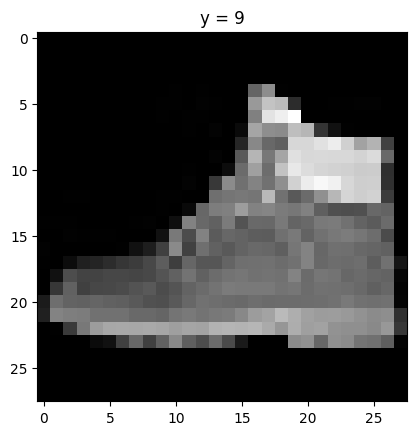

In [28]:
showData(data[90], image_size)

In [45]:
# Autoencoder based model for image reconstruction
class ImageEncoderModel(nn.Module):

  def __init__(self, image_size, latent_dim):
     super(ImageEncoderModel, self).__init__()

     self.image_size = image_size
     self.latent_dim = latent_dim
     self.flatten = nn.Flatten()
     self.ln1 = nn.Linear(in_features=self.image_size*self.image_size,
                          out_features= self.latent_dim)
     self.relu1 = nn.ReLU()

     self.ln2 = nn.Linear(in_features=self.latent_dim,
                          out_features=self.image_size*self.image_size)
     self.sigmoid = nn.Sigmoid()
     self.unflatten = nn.Unflatten(1, torch.Size([1, self.image_size, self.image_size]))

  def forward(self, x):

    x = self.flatten(x)
    x = self.ln1(x)
    x = self.relu1(x)

    x = self.ln2(x)
    x = self.sigmoid(x)
    x = self.unflatten(x)

    return x


In [ ]:
# printing the model summary
from torchsummary import summary
model1 = ImageEncoderModel(28, 64)
summary(model1, input_size=(1,28,28))

In [48]:
print(model1)

ImageEncoderModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (ln1): Linear(in_features=784, out_features=64, bias=True)
  (relu1): ReLU()
  (ln2): Linear(in_features=64, out_features=784, bias=True)
  (sigmoid): Sigmoid()
  (unflatten): Unflatten(dim=1, unflattened_size=torch.Size([1, 28, 28]))
)


In [54]:
# training model
def train_model(model, train_loader, validation_loader, optimizer, image_size, n_epochs=5):
  # global variable
  N_test = len(get_validate_dataset(image_size))
  print(" Number of test images: ", N_test)
  accuracy_list = []
  loss_list = []
  criterion = nn.MSELoss()

  for epoch in range(n_epochs):

    for x, label in train_loader:
      # call train() on model which extents nn.module
      #if cuda:
      #  x, label = x.cuda(), label.cuda()
      #  model = model.cuda()

      model.train()
      # reset the weights derivative values
      optimizer.zero_grad()
      # predict the output
      pred = model(x)
      # calculate Mean Squared loss
      loss = criterion(pred, x)
      # Calculate derivative of loss w.r.t weights
      loss.backward()
      # update the weights value
      optimizer.step()

      loss_list.append(loss.data)

  return loss_list

In [53]:
lr = 0.0005
latent_dim = 64
epochs = 10
model = ImageEncoderModel(image_size, latent_dim)
optimizer = torch.optim.Adam(model.parameters())



In [55]:
loss = train_model(model, train_dataloader, validate_dataloader, optimizer, image_size, epochs)

 Number of test images:  10000


In [ ]:
# plot the loss graph
plt.plot(loss)
plt.xlabel("batch iterations ")
plt.ylabel("Cost/total loss ")
plt.show()

In [ ]:
  validate_data = get_validate_dataset(image_size)
  showData(validate_data[5], image_size)

In [58]:
# Evaluate the model on new image
model.eval()
output = model(validate_data[5][0])

In [59]:
output.shape

torch.Size([1, 1, 28, 28])

In [7]:
def showDataPredicted(data_point, image_size):
    plt.imshow(data_point.numpy().reshape(image_size, image_size), cmap='gray')
    plt.show()

In [ ]:
showDataPredicted(output.detach(), image_size)